In [1]:
import numpy as np
import scipy.linalg as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from itertools import product

sns.set_style('whitegrid')

sns.set_context('notebook')

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200

%load_ext autoreload
%autoreload 2

dev = 'cuda'

In [2]:
from utils import *
from embed import *

models = ["wr-4-8", "allcnn-96-144", "fc-1024-512-256-128"]
opts = ["adam", "sgdn", "sgd"]

In [3]:
T = 45000
ts = []
for t in range(T):
    if t < T//10:
        if t % (T//100) == 0:
            ts.append(t)
    else:
        if t % (T//10) == 0 or (t == T-1):
            ts.append(t)
ts = np.array(ts)
tmap = {i:ts[i] for i in range(len(ts))}
pts = np.concatenate([np.arange(ts[i], ts[i+1], (ts[i+1]-ts[i]) // 5) for i in range(len(ts)-1)])
N = len(pts)

## Bhat vs InPCA

In [70]:
loc = 'inpca_results'
fn = 'yh_new_interpolate_with_avg'
w = th.load(os.path.join(loc,'w_%s.p'%fn))
dc = th.load(os.path.join(loc,'didx_%s.p'%fn)).reset_index()

In [89]:
rmean = w.mean(1, keepdims=True)
w_ = w - rmean
cmean = w_.mean(0, keepdims=True)
w_ = w_ - cmean
# np.allclose(w_, l@w@l)

In [90]:
l = np.eye(w.shape[0]) - 1.0/w.shape[0]
w = -l @ w @ l 
n = len(w)
r = proj_(w, n, 500)

Projecting


In [4]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs':[200, 400], 'aug':[True], 'wd':[0.0], 'bn':[True], 'm':models, 'opt':opts},
           avg_err=True, keys=['yh'], drop=False, probs=True)

Index(['seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh', 'f', 'e',
       'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 3600


In [5]:
d = avg_model(d, groupby=['m', 'opt', 't', 'bs'], probs=True, get_err=True, keys=['yh'],
              update_d=True, compute_distance=False, dev='cuda')['d']

In [6]:
d = interpolate(d, ts, pts, columns=['seed', 'm', 'opt', 'avg', 'bs'], keys=['yh'], dev='cuda')

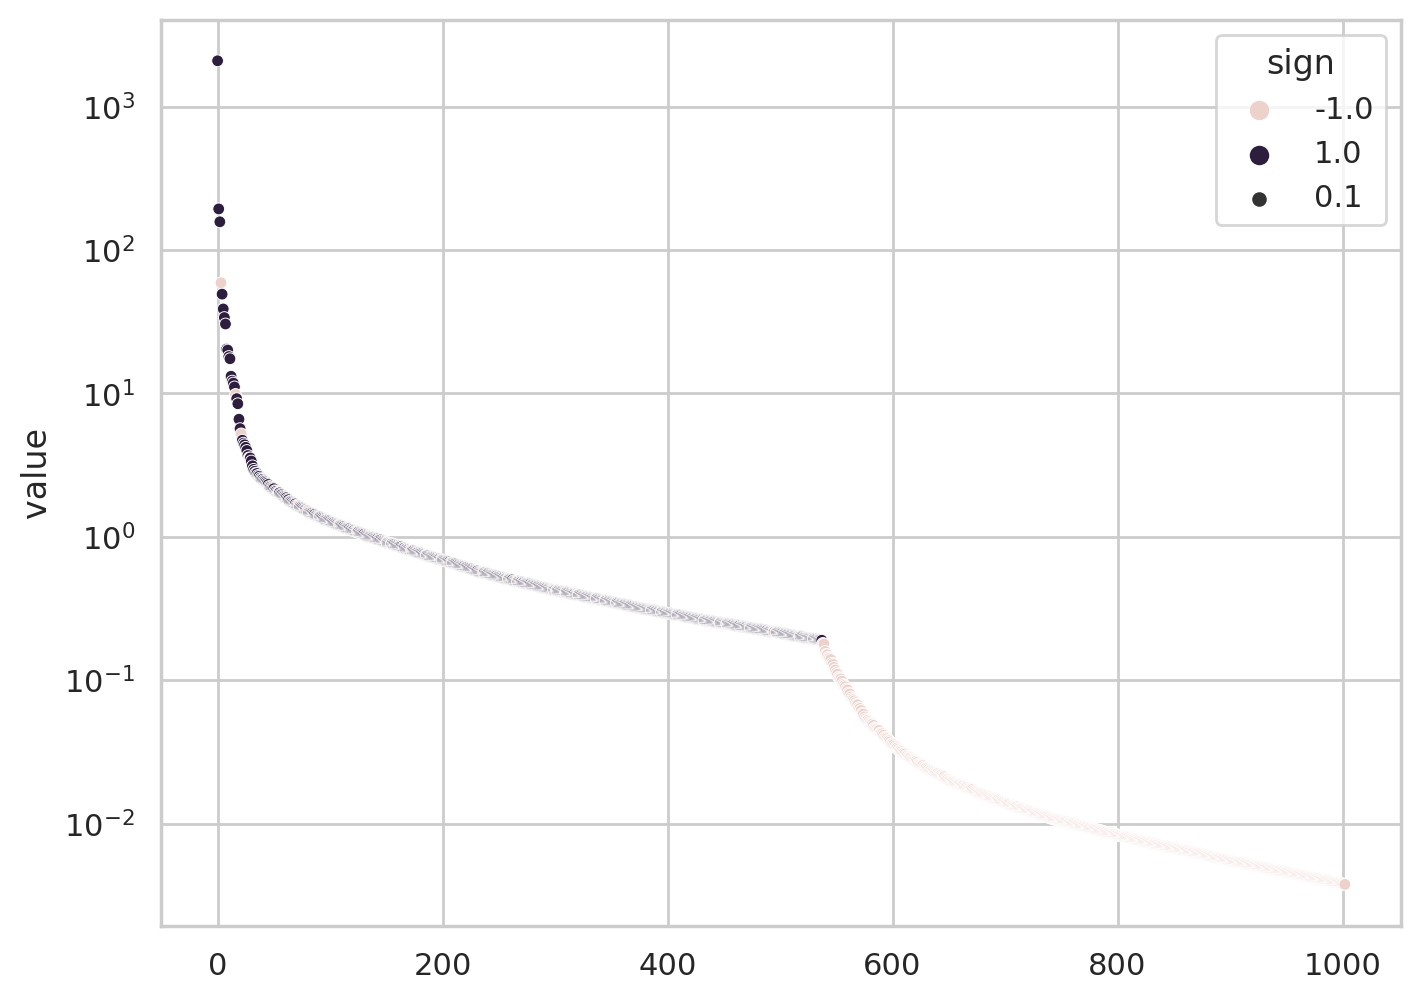

In [6]:
df = pd.DataFrame(np.vstack([np.abs(r['e']), np.sign(r['e'])]).T, columns=['value', 'sign'])
# plt.plot(df['value'])
ax = sns.scatterplot(data=df, x=df.index, y='value', hue='sign', size=0.1)
ax.set_yscale('log')

In [107]:
from distance import dbhat, dinpca

dists = []
k = 'yh'
m = models[0]
o = opts[0]
seeds = dc['seed'].unique()

avg_fnorm = []
for ne in np.concatenate([np.arange(10, 50, 10), np.arange(50, 500, 100), np.arange(500,1000, 200)]):
    for s1 in range(len(seeds)):
        for s2 in range(s1+1, len(seeds)):
            ne = int(ne)
            i1 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seeds[s1]}")
            i2 = get_idx(dc, f"m=='{m}' & opt=='{o}' & seed=={seeds[s2]}")
            di = dinpca(th.Tensor(r['xp'][i1, :ne]), th.Tensor(r['xp'][i2, :ne]), th.Tensor(np.sign(r['e'][:ne])))
#             di = di + th.Tensor(cmean[:, i1]).cuda() + th.Tensor(rmean[i2, :]).cuda()
#             db = dbhat(th.Tensor(np.stack(d.iloc[i1][k])), th.Tensor(np.stack(d.iloc[i2][k])))
            db = th.Tensor(w)[:, i1][i2].to(dev)
            avg_fnorm.append(dict(fnorm=th.norm(di-db).item(), ne=ne, label=(seeds[s1], seeds[s2])))
    #         dists.append(dict(dist=di.cpu(), distf='inpca', s1=seeds[s1], s2=seeds[s2]))
    #         dists.append(dict(dist=db.cpu()**2, distf='bhat', s1=seeds[s1], s2=seeds[s2]))
dists = pd.DataFrame(dists)

<AxesSubplot:xlabel='ne', ylabel='fnorm'>

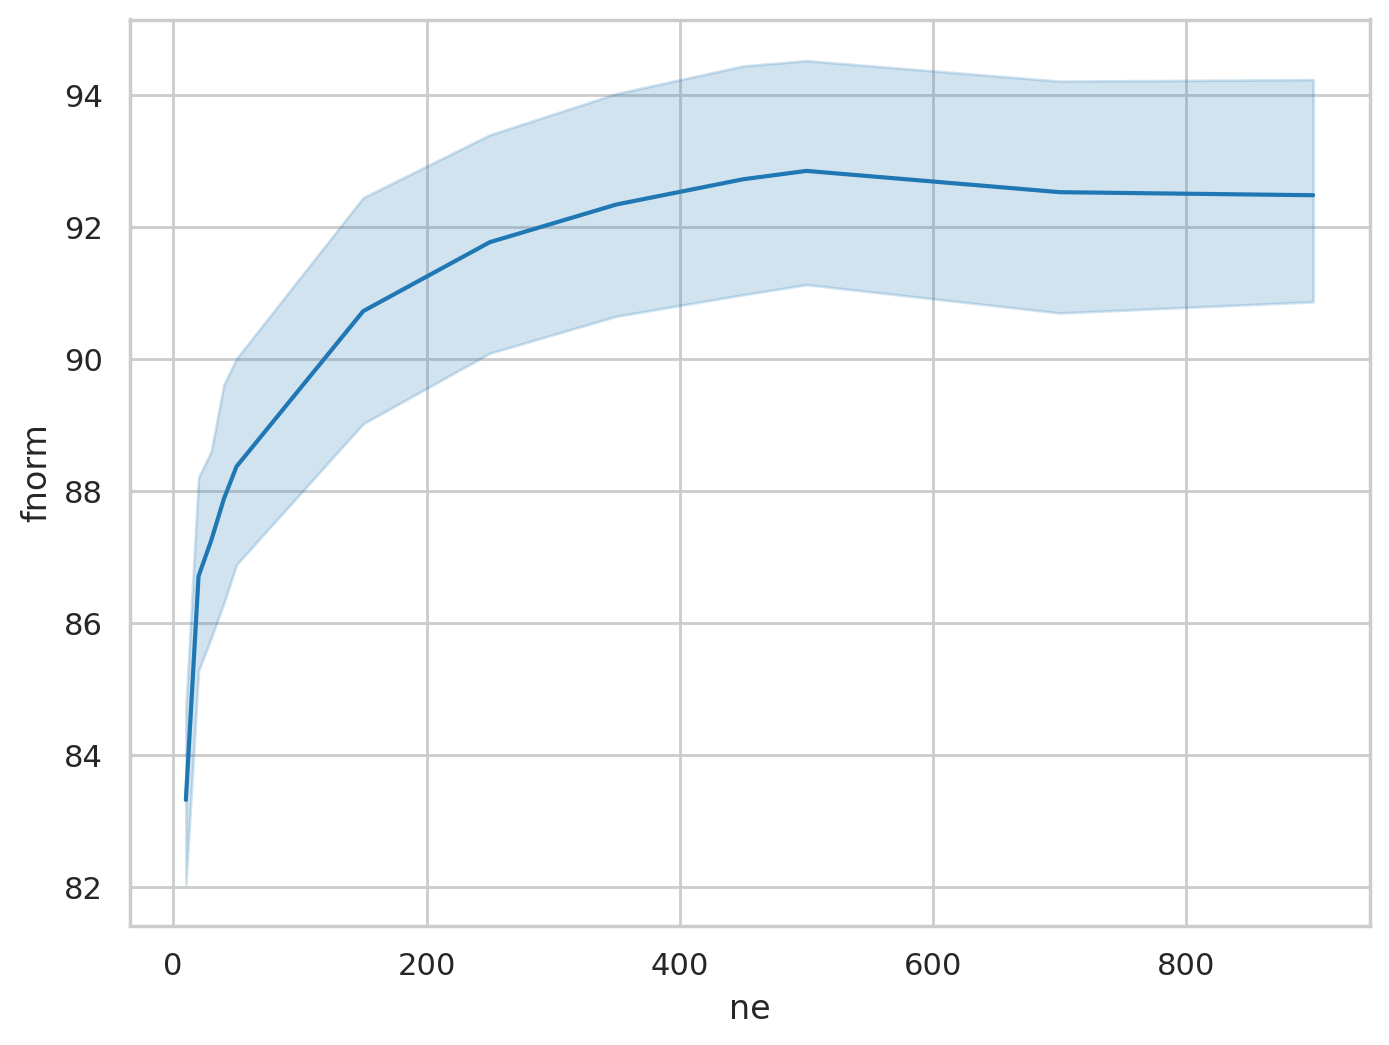

In [108]:
df = pd.DataFrame(avg_fnorm)
sns.lineplot(data=df, x='ne', y='fnorm')

## Distance to avg

In [11]:
dists = []
for s in np.concatenate([[0], np.arange(0.05, 0.5, 0.05)]):
    k = 'yh'
    o = opts[0]
    m = models[0]
    i1 = get_idx(d, f"m=='{m}' & opt=='{o}' & bs==200 & avg==True")
    for seed in d['seed'].unique():
        if seed < 0:
            continue
        i2 = get_idx(d, f"m=='{m}' & opt=='{o}' & bs==200& seed=={seed}")
        pdists = dbhat(th.Tensor(np.stack(d.iloc[i1][k].values)), th.Tensor(np.stack(d.iloc[i2][k].values))
#                     di = dinpca(th.Tensor(r['xp'][i1]), th.Tensor(r['xp'][i2]), th.Tensor(np.sign(r['e'])))
#                     p = th.exp(-di/(2*s)).sum(1)
#                     kdist = (th.exp(-di/(2*s)) * dist).sum(1) / p
        kdist = dp2t(th.Tensor(np.stack(d.iloc[i1][k].values)), th.Tensor(np.stack(d.iloc[i2][k].values)), s=s)
        if s == 0:
            kdist = dp2t(th.Tensor(np.stack(d.iloc[i1][k].values)), th.Tensor(np.stack(d.iloc[i2][k].values)), 
                         use_min=True)
        for i in range(N):
            dists.append(dict(dist=kdist[i].item(),
                              m=m, opt=o, 
                              t=pts[i], key=k, seed=seed, s=s))

Text(0.5, 1.0, 'weighted by $exp(-d^2/2s) * dy$')

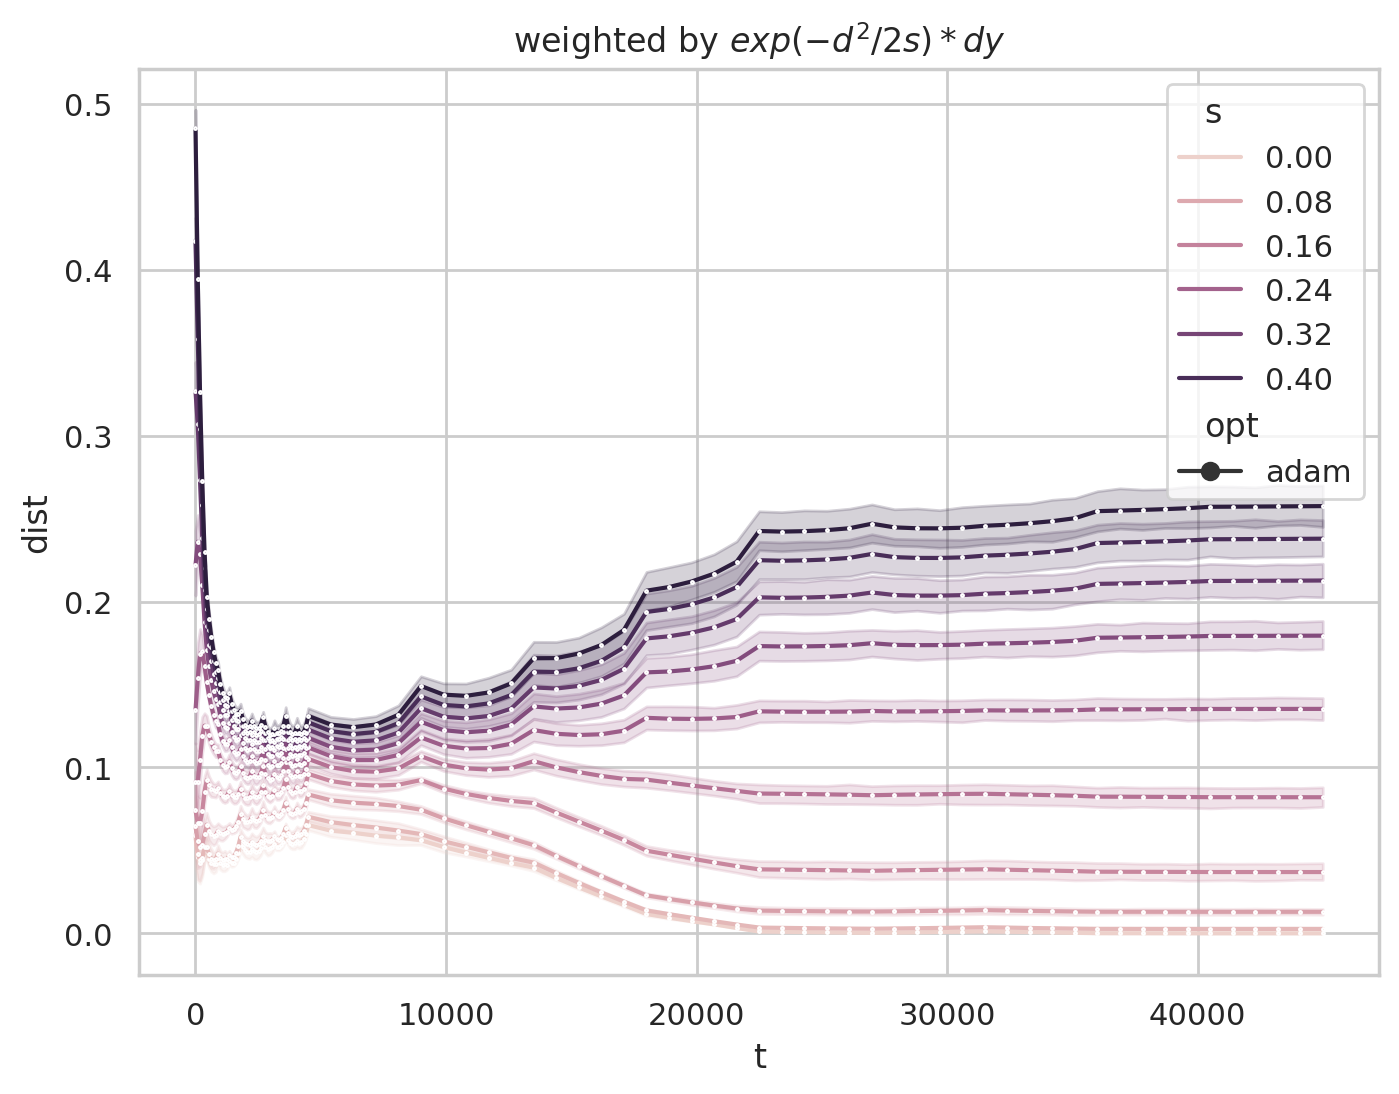

In [12]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='s', style='opt', markers=True, markersize=1)
ax.set_title('weighted by $exp(-d^2/2s) * dy$')

In [15]:
dists = []
k = 'yh'
for bs in [200, 400]:
    for o in opts:
        for m in models:
            
            i1 = get_idx(dc, f"m=='{m}' & opt=='{o}' & bs=={bs} & avg==True")
            for seed in d['seed'].unique():
                if seed < 0:
                    continue
                i2 = get_idx(dc, f"m=='{m}' & opt=='{o}' & bs=={bs} & seed=={seed}")
                kdist = dp2t(th.Tensor(np.stack(d.iloc[i1][k].values)), 
                             th.Tensor(np.stack(d.iloc[i2][k].values)), use_min=True)
                for i in range(N):
                    dists.append(dict(dist=kdist[i].item(), m=m, opt=o, 
                                      t=pts[i], key=k, seed=seed, s=s))

NameError: name 'dc' is not defined

Text(0.5, 1.0, 'distance to average model')

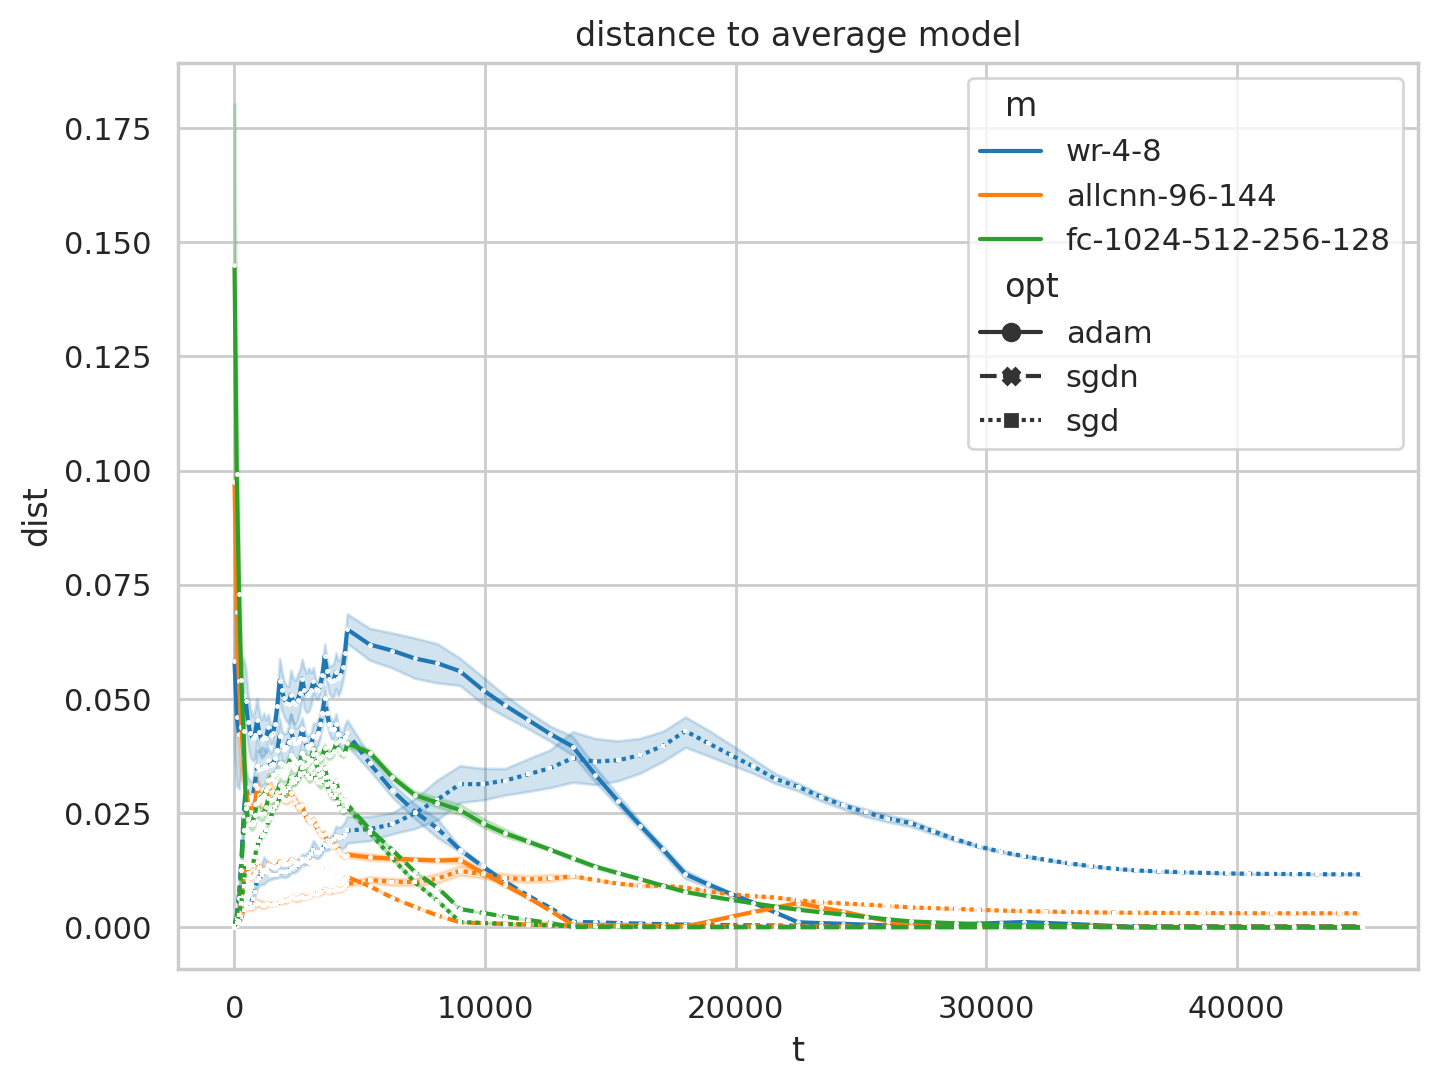

In [152]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='m', style='opt', markers=True, markersize=1)
ax.set_title('distance to average model')

Text(0.5, 1.0, 'dbhat weighted sum')

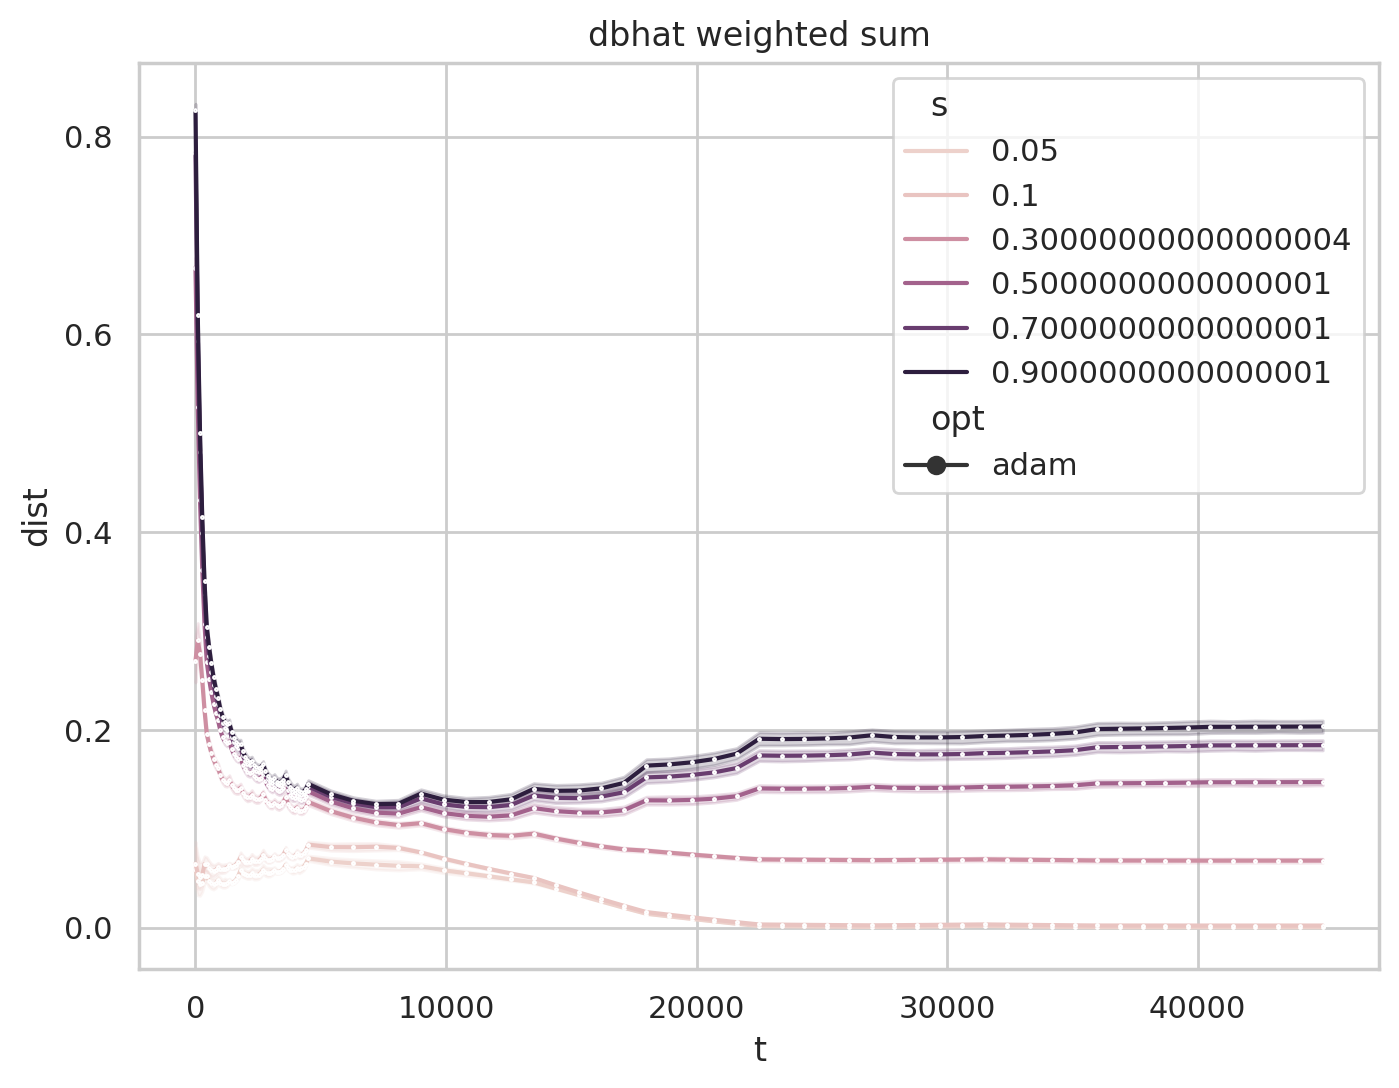

In [128]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='s', style='opt', markers=True, markersize=1)
ax.set_title('dbhat weighted sum')

Text(0.5, 1.0, 'dt & dbhat weighted sum')

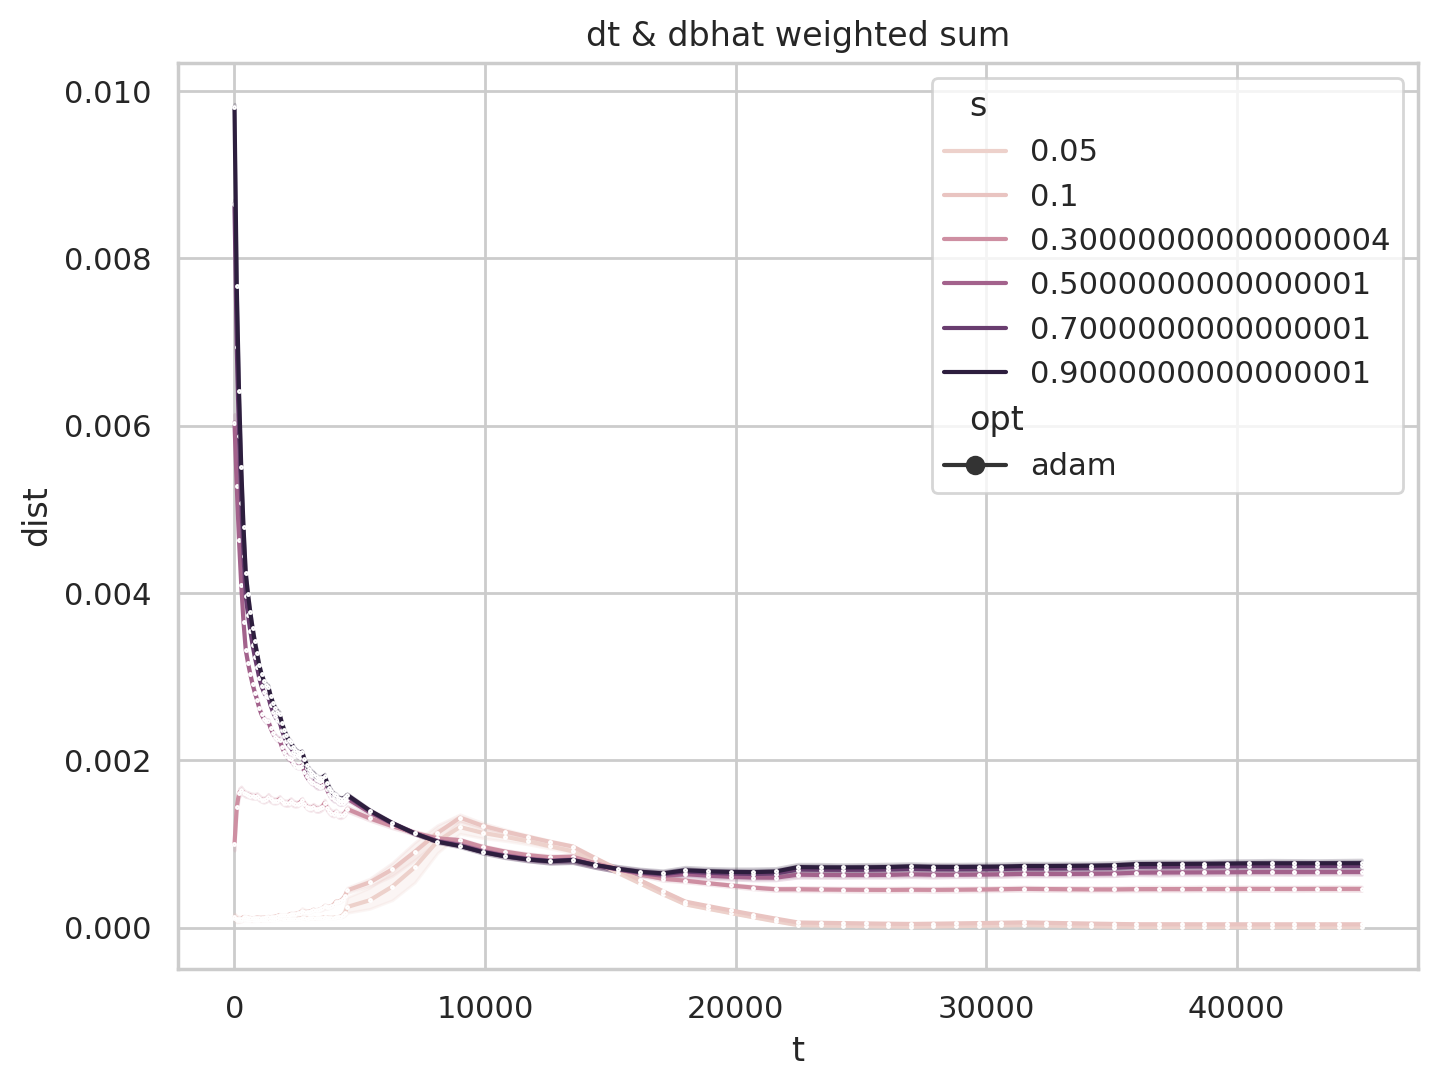

In [124]:
dists = pd.DataFrame(dists)
ax=sns.lineplot(data=dists.iloc[get_idx(dists,"key=='yh'")], x='t', y='dist', hue='s', style='opt', markers=True, markersize=1)
ax.set_title('dt & dbhat weighted sum')

## Pairwise Distance

In [5]:
loc = 'results/models/new'
d = load_d(loc, cond={'bs':[200, 400], 'aug':[True], 'wd':[0.0], 'bn':[True], 'm':models, 'opt':opts},
           avg_err=True, drop=True, probs=True)

d = avg_model(d, groupby=['m', 'opt', 't', 'bs'], probs=True, get_err=True, 
              update_d=True, compute_distance=False, dev='cuda')['d']
d = interpolate(d, ts, pts, columns=['seed', 'm', 'opt', 'avg', 'bs'], keys=['yh'], dev='cuda')

Index(['index', 'seed', 'm', 'opt', 'lr', 'wd', 'bn', 'aug', 'bs', 't', 'yh',
       'f', 'e', 'yvh', 'fv', 'ev', 'err', 'verr', 'favg', 'vfavg'],
      dtype='object') 3200


In [22]:
dists, configs = pairwise_dist_batch(d, groups=['m', 'opt', 'seed', 'bs'], s=0.1, batch=2)

[0 1] [0 1]


RuntimeError: CUDA out of memory. Tried to allocate 6.87 GiB (GPU 0; 22.20 GiB total capacity; 16.17 GiB already allocated; 1.59 GiB free; 19.10 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
th.save({'dists':dists, 'configs':configs}, os.path.join(loc, 'pairwise_dists_bs.p'))

<AxesSubplot:>

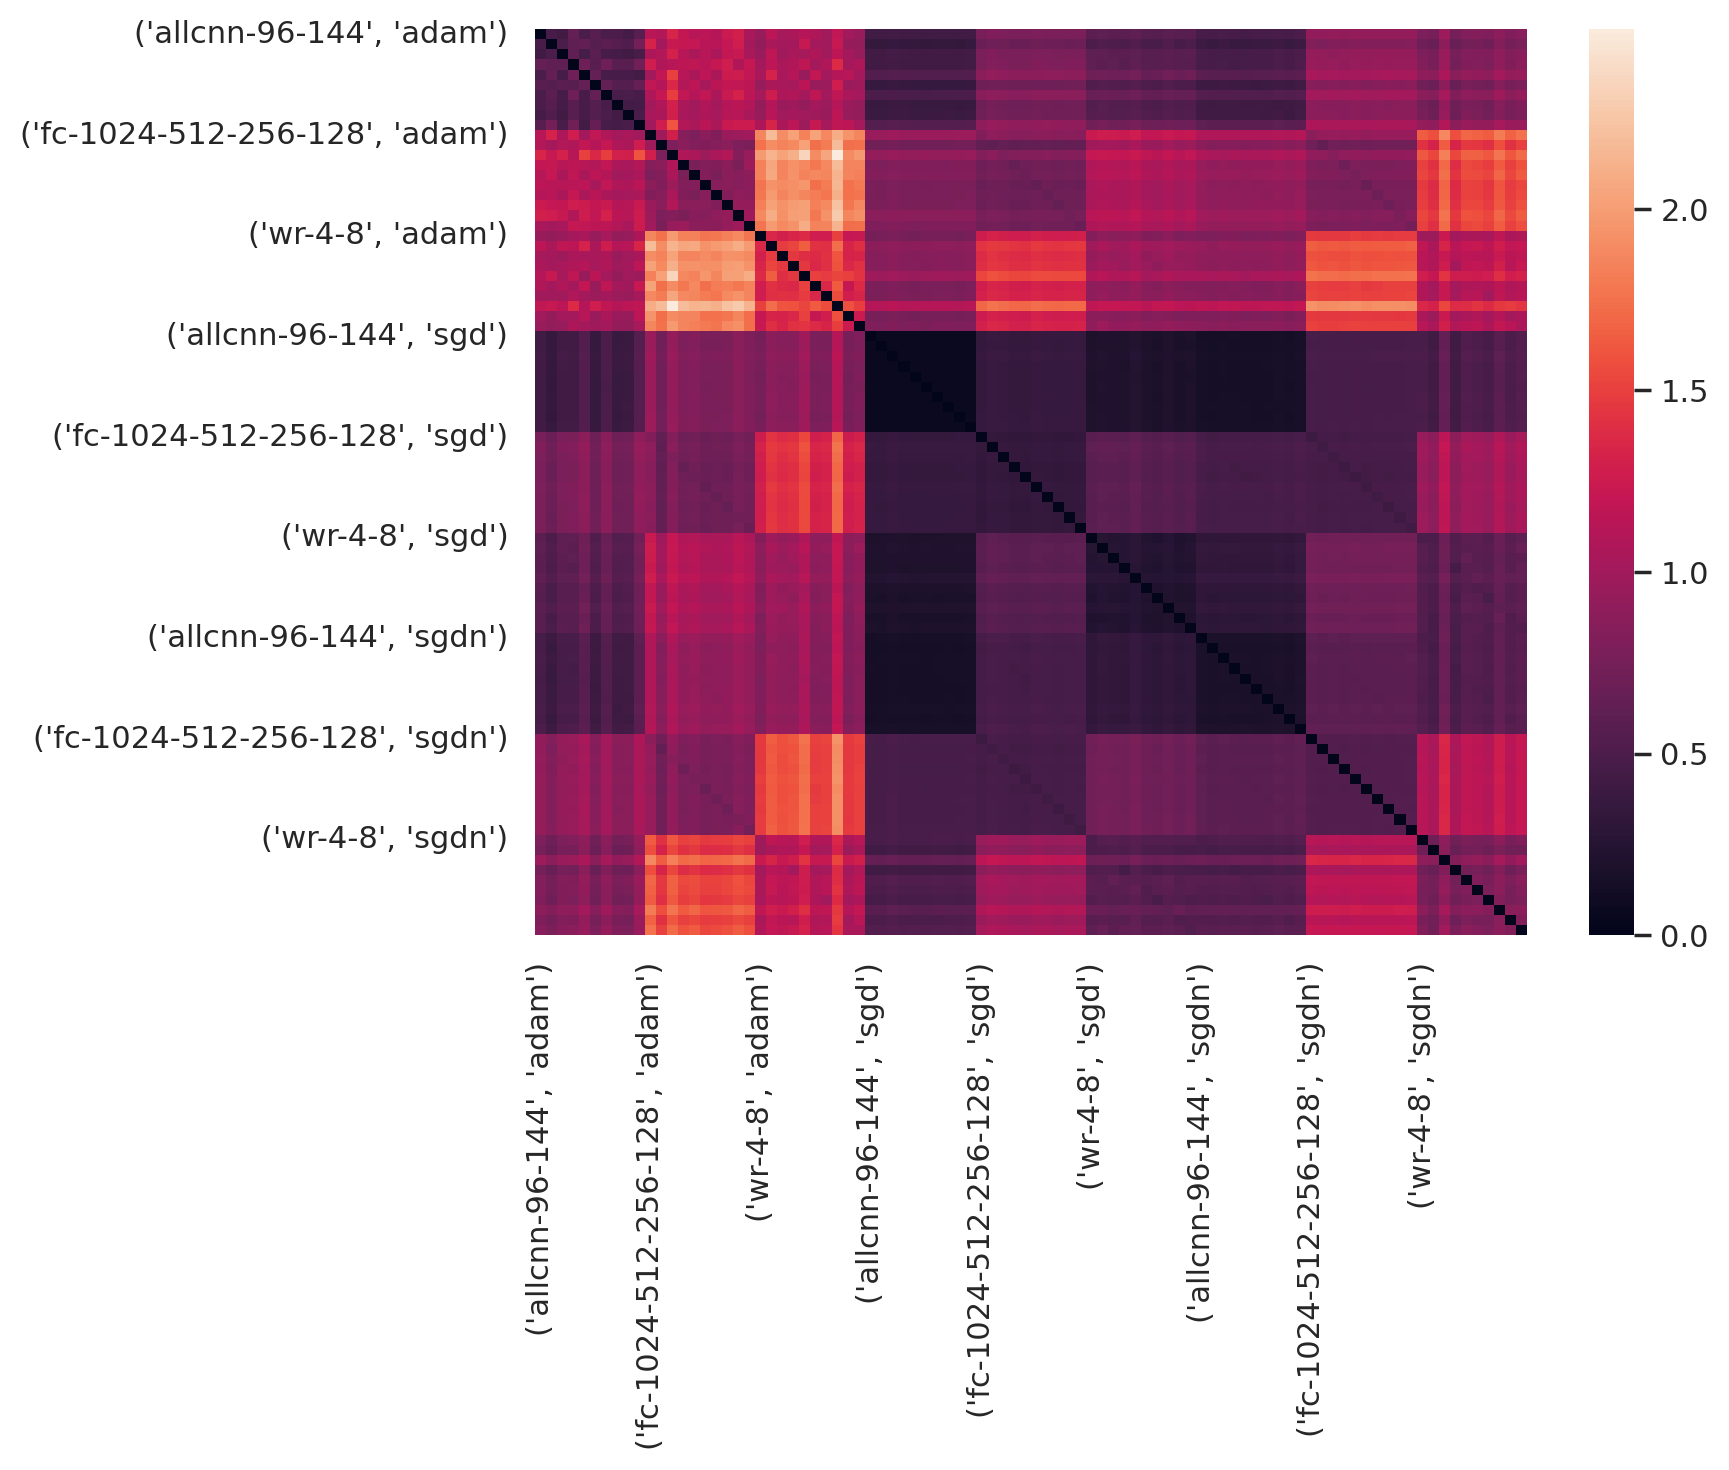

In [13]:
idxs = []
columns = []
for (i, c) in enumerate(configs):
    if c[-1] != -1:
        idxs.append(i)
        columns.append(c[:2])
idxs = np.array(idxs)
columns = np.stack(columns)
cidxs = np.lexsort(columns.T)
idxs = idxs[cidxs]

didxs=dists_sym[:, idxs][idxs]
sns.heatmap(pd.DataFrame(didxs, columns=columns[cidxs], index=columns[cidxs]), xticklabels=10, yticklabels=10)

In [115]:
import torch.nn.functional as F
avg_dists = F.conv2d(th.Tensor(didxs).unsqueeze(0).unsqueeze(0), weight=th.ones(1,1, 10, 10)/100, stride=10)

<AxesSubplot:>

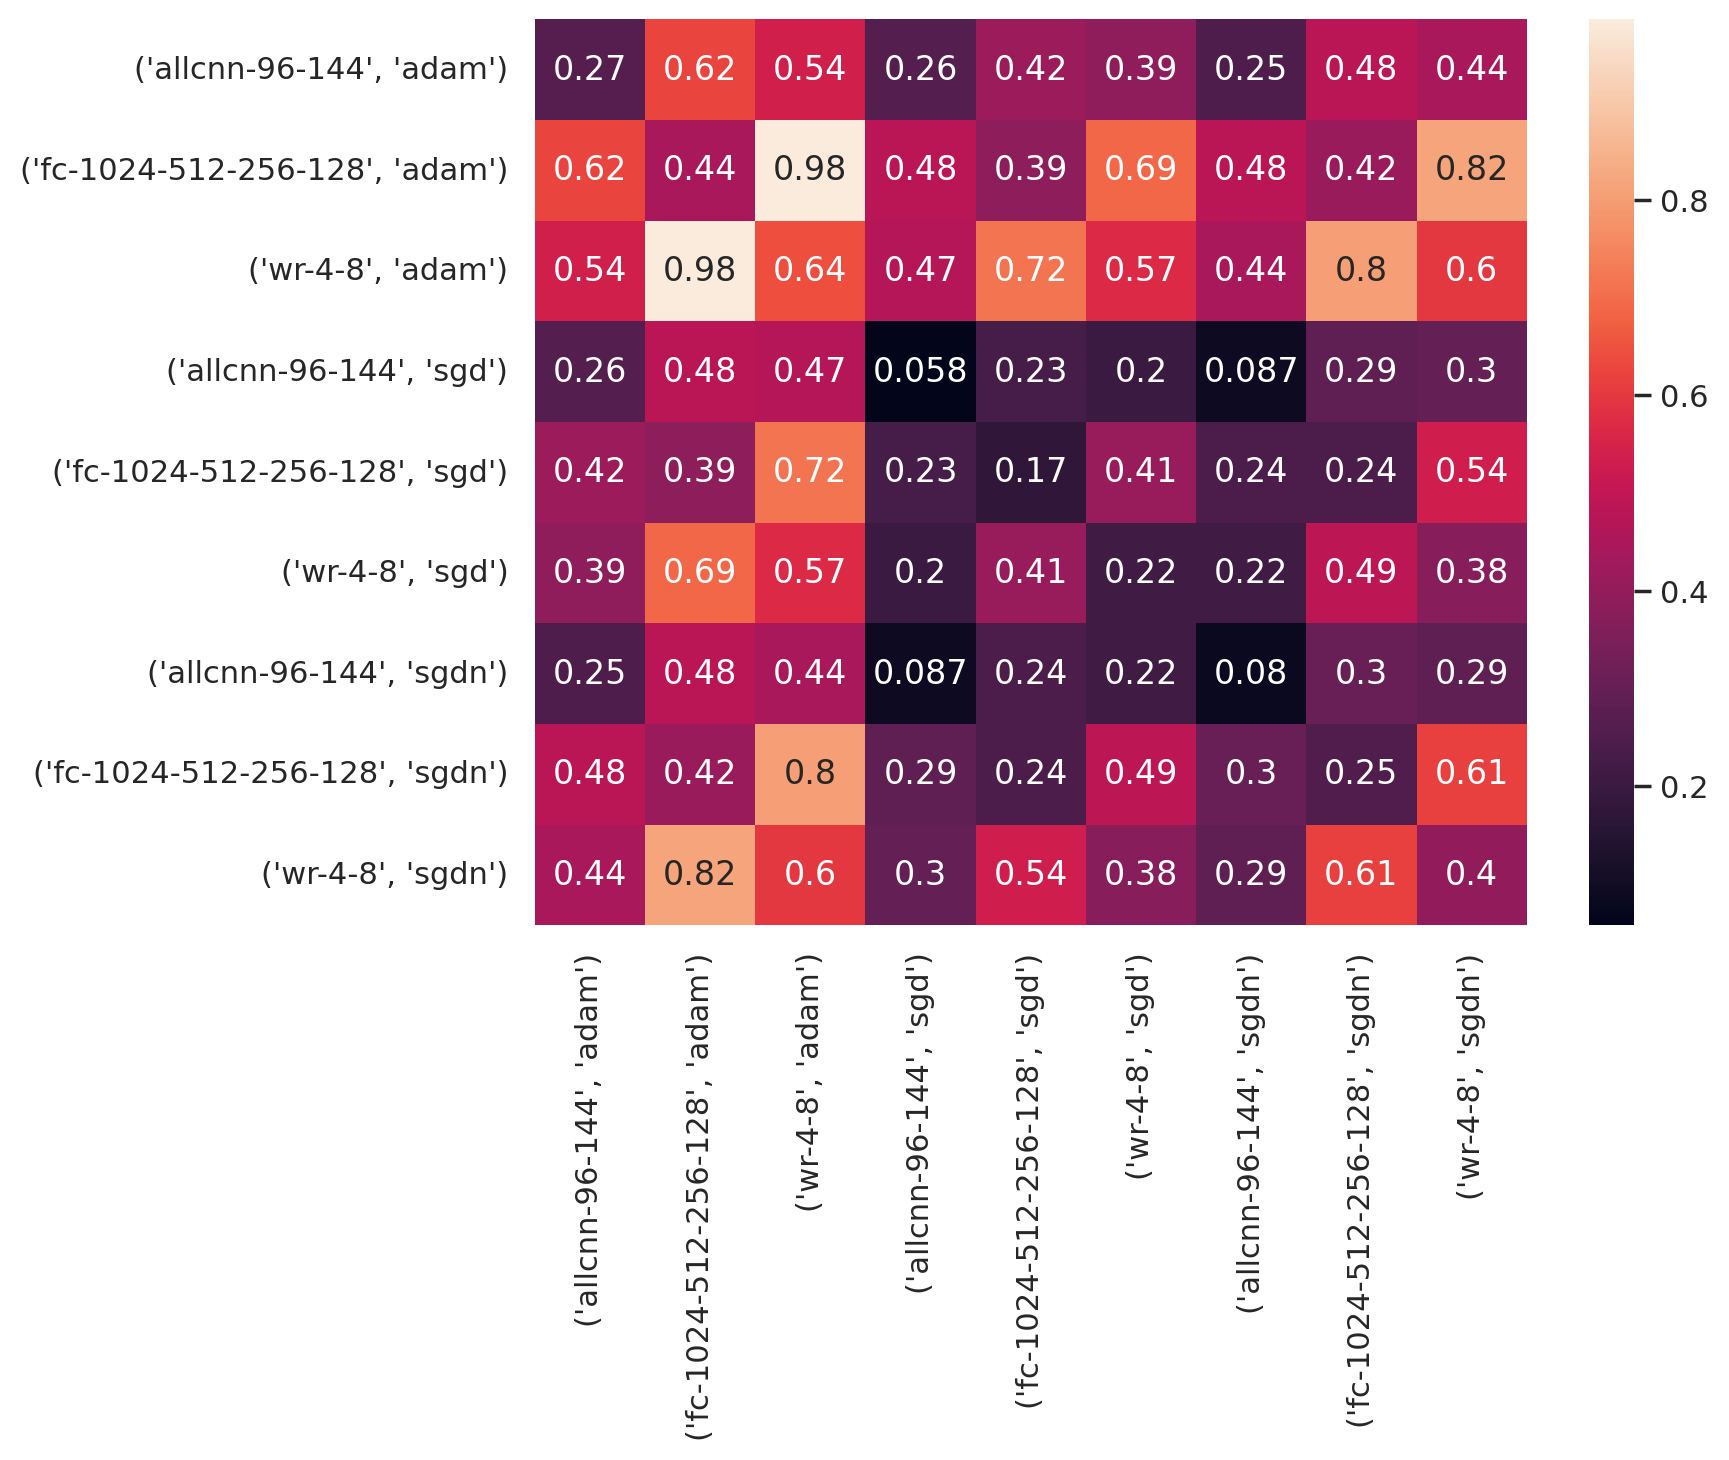

In [116]:
sns.heatmap(pd.DataFrame(avg_dists.squeeze().numpy(), columns=columns[cidxs][::10], index=columns[cidxs][::10]), annot=True)

In [110]:
c

('wr-4-8', 'sgdn', 51)

(10, 96, 50000, 10)

<AxesSubplot:>

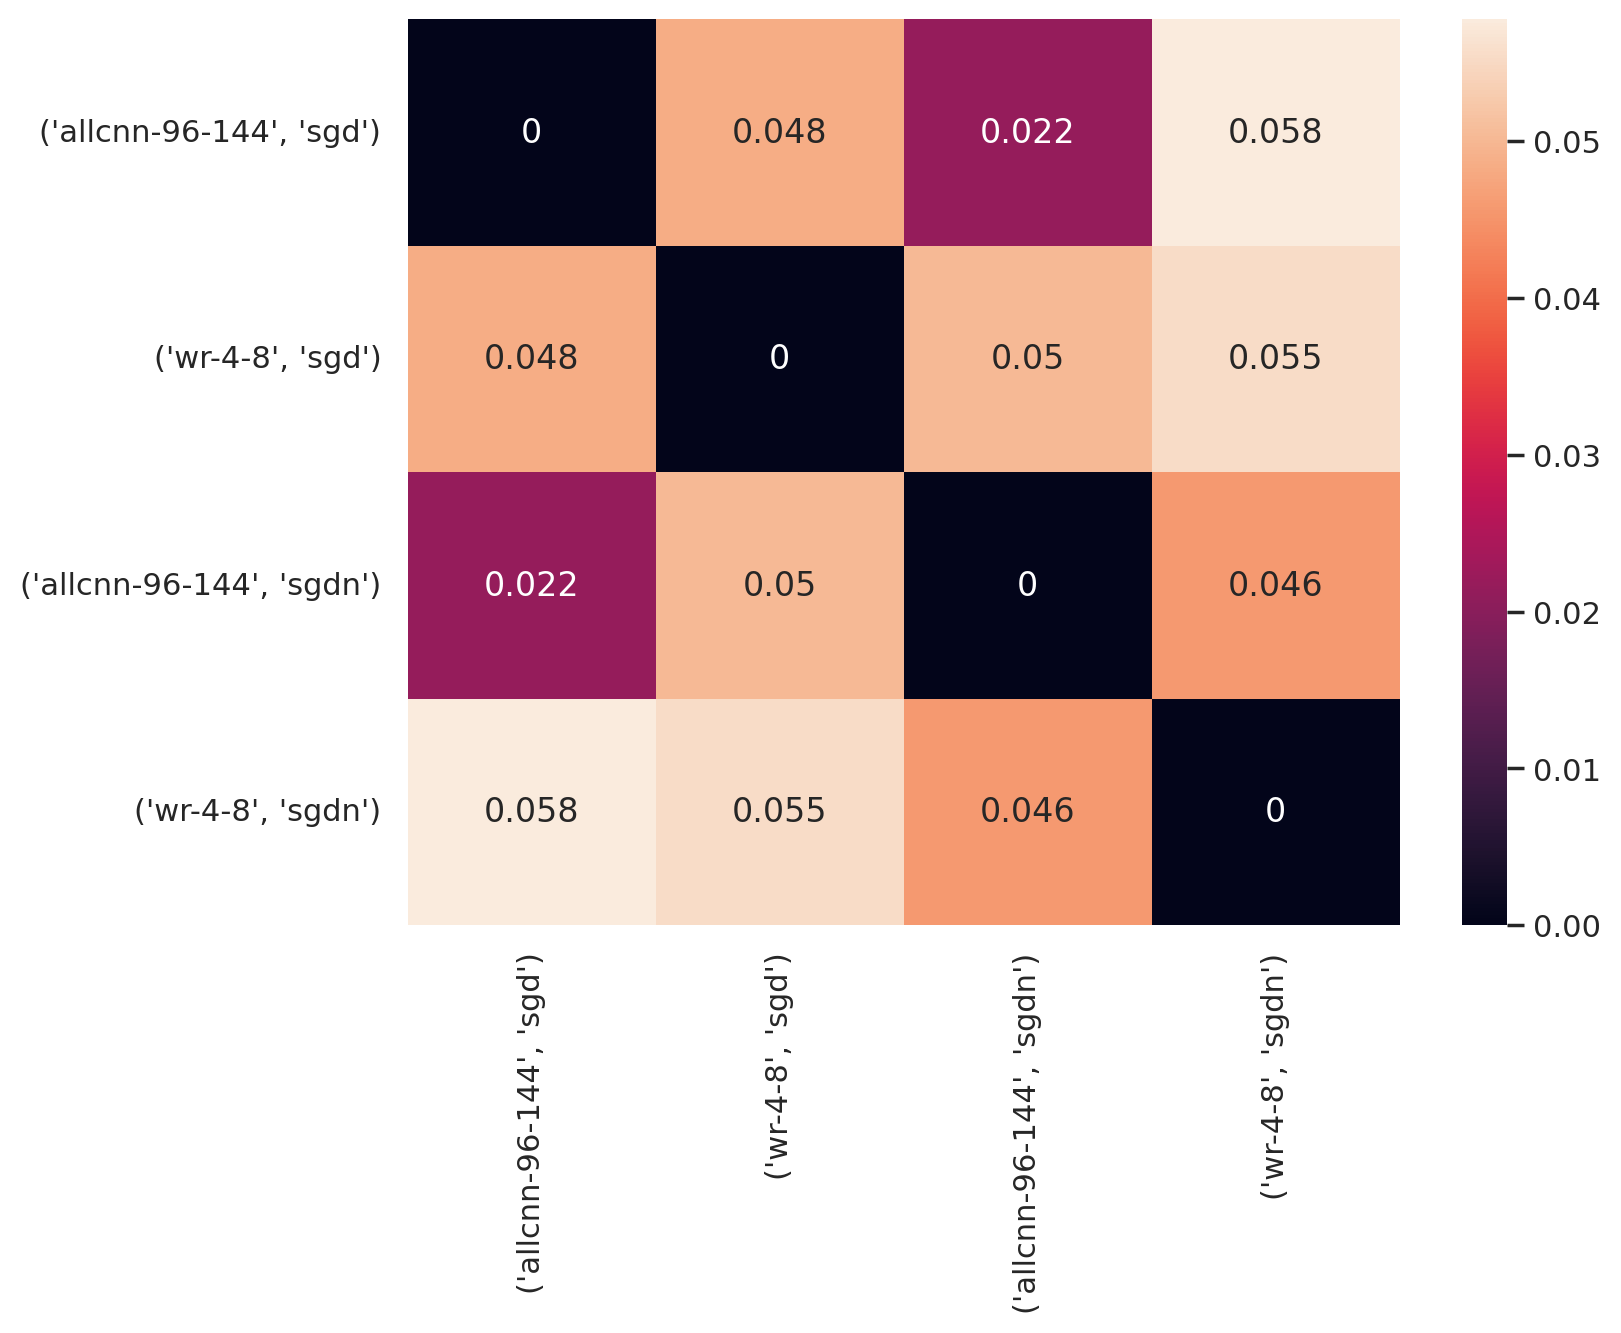

In [112]:
idxs = []
columns = []
for (i, c) in enumerate(configs):
    if c[-1] == -1 and c[0] != 'fc-1024-512-256-128' and c[1] != 'adam':
        idxs.append(i)
        columns.append(c[:2])
idxs = np.array(idxs)
columns = np.stack(columns)
cidxs = np.lexsort(columns.T)
idxs = idxs[cidxs]
columns = columns[cidxs]

didxs=dists_sym[:, idxs][idxs]
sns.heatmap(pd.DataFrame(didxs, columns=columns, index=columns), xticklabels=1, yticklabels=1, annot=True)

In [259]:
d.iloc[groups[configs[0]]]['yh']

0     [[0.023180362, 0.4258937, 0.008179637, 0.00833...
1     [[0.019121487, 0.34148857, 0.014114597, 0.0307...
2     [[0.01506261, 0.25708342, 0.020049557, 0.05316...
3     [[0.011003735, 0.17267829, 0.025984516, 0.0755...
4     [[0.0069448585, 0.08827316, 0.031919476, 0.098...
                            ...                        
91    [[1.104647e-12, 2.619243e-11, 3.782961e-07, 9....
92    [[9.855612e-13, 2.2514766e-11, 3.2590418e-07, ...
93    [[8.6647557e-13, 1.88371e-11, 2.7351223e-07, 7...
94    [[7.4738983e-13, 1.5159436e-11, 2.211203e-07, ...
95    [[6.283041e-13, 1.1481771e-11, 1.6872836e-07, ...
Name: yh, Length: 96, dtype: object

<AxesSubplot:>

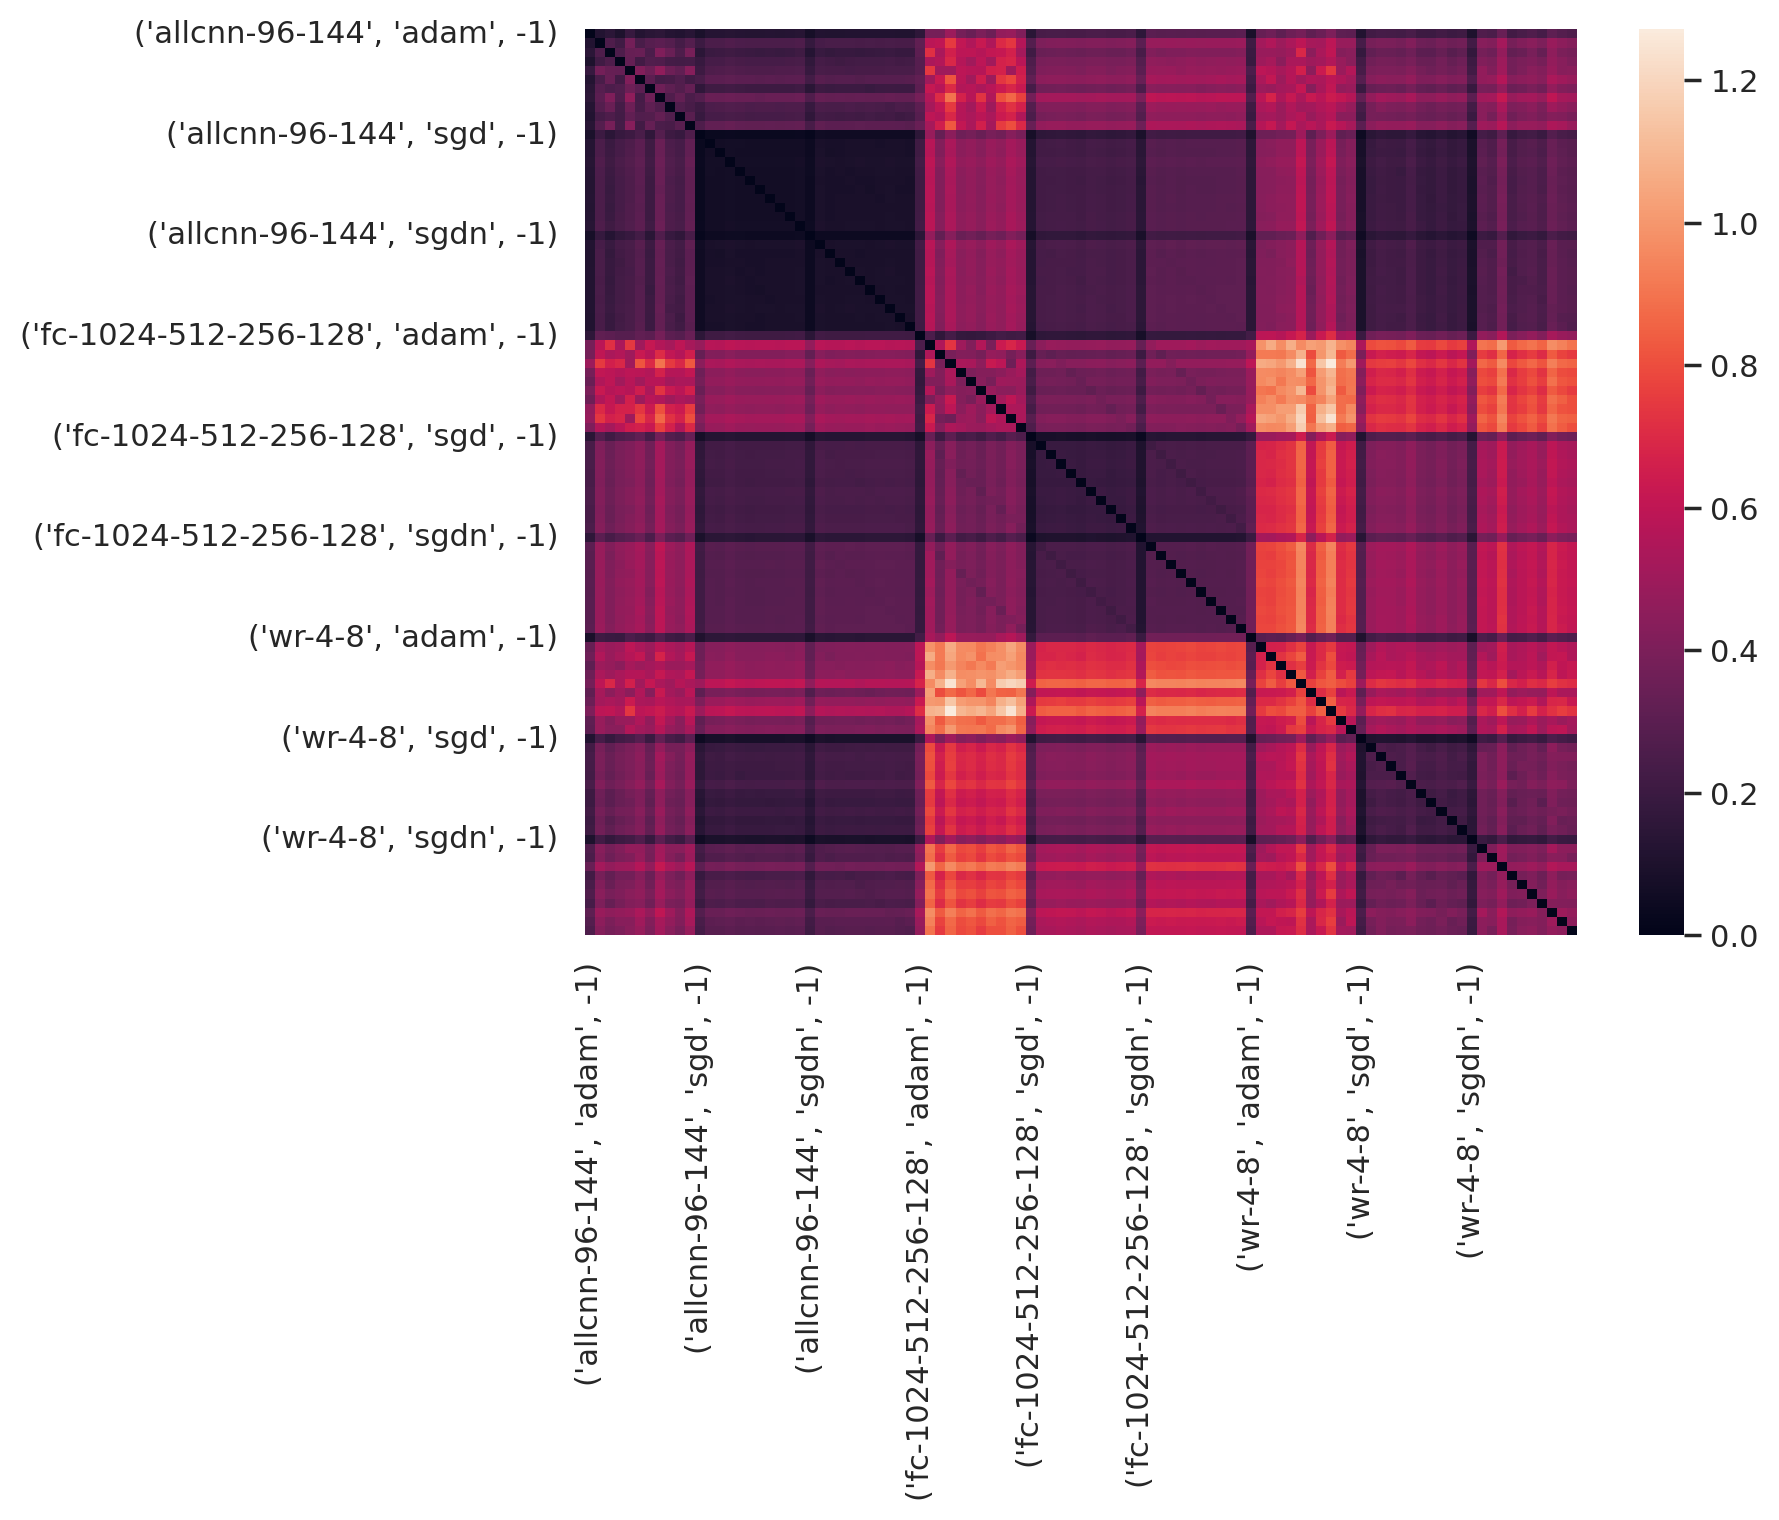

In [30]:
sns.heatmap(pd.DataFrame(dists_sym, columns=configs, index=configs), xticklabels=11, yticklabels=11)

In [89]:
data = []
d2 = np.arange(1, 11)
d1 = [22]
idxs = np.concatenate([d1, d2])
didxs=dists[:, :, idxs][:, idxs]
for t in range(len(didxs)):
    for (i, di) in enumerate(d1):
        for (j, dj) in enumerate(d2):
            d_ = didxs[t, i, len(d1)+j] + didxs[t, len(d1)+j, i]
            data.append(dict(t=t, label=(configs[di], configs[dj]), d=d_/2))
d2 = np.arange(22, 33)
d1 = [0]
idxs = np.concatenate([d1, d2])
didxs=dists[:, :, idxs][:, idxs]
for t in range(len(didxs)):
    for (i, di) in enumerate(d1):
        for (j, dj) in enumerate(d2):
            d_ = didxs[t, i, len(d1)+j] + didxs[t, len(d1)+j, i]
            data.append(dict(t=t, label=(configs[di], configs[dj]), d=d_/2))

In [172]:
X = x1[:2, :]
Y = x1[-2:, :]

In [170]:
from distance import dp2t_batch

In [173]:
x = X.flatten(0, 1)
y = Y.flatten(0,1)

In [194]:
Nx, Tx = X.shape[:2]

In [12]:
dists_sym = (dists + dists.T)/2